<a href="https://colab.research.google.com/github/kvasilisav/ML_HomeAssignments/blob/main/ClassicML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ucimlrepo as uci
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier, Pool

from tqdm import tqdm

# Проблематика

In [ ]:
dataset = uci.fetch_ucirepo(id=149)

print(dataset.metadata.name, '\n')
print(dataset.metadata.abstract, '\n')
print(dataset.metadata.additional_info.summary, '\n')

Statlog (Vehicle Silhouettes) 

3D objects within a 2D image by application of an ensemble of shape feature extractors to the 2D silhouettes of the objects. 

The purpose is to classify a given silhouette as one of four types of vehicle, using  a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.  

HISTORY:

This data was originally gathered at the TI in 1986-87 by JP Siebert. It was partially financed by Barr and Stroud Ltd. The original purpose was to find a method of distinguishing 3D objects within a 2D image by application of an ensemble of shape feature extractors to the 2D silhouettes of the objects. Measures of shape features extracted from example silhouettes of objects to be discriminated were used to generate a classification rule tree by means of computer induction.

This object recognition strategy was successfully used to discriminate between silhouettes of model cars, vans and buses viewed from constrained elevati

Задача состоит в классификации силуэтов транспортных средств на изображениях, полученных под разными углами обзора. Исходные данные представляют собой 2D-силуэты четырёх типов транспортных средств:

- Двухэтажный автобус (double-decker bus),

- Фургон Chevrolet (Chevrolet van),

- Легковой автомобиль Saab 9000,

- Легковой автомобиль Opel Manta 400.

Основные сложности:

- Силуэты могут быть сняты под разными углами (0°–360°), что влияет на их форму.

- Некоторые классы (особенно два легковых автомобиля) могут быть визуально похожи, что усложняет их различение.

- Данные содержат геометрические и статистические признаки, извлечённые из силуэтов (моменты, компактность, прямоугольность и др.), но не сами изображения.

Для решения задачи я выбрала три алгоритма:
- Логистическая регрессия ,

- Случайный лес,

- CatBoost

In [ ]:
from sklearn.datasets import fetch_openml

vehicle = fetch_openml(name="vehicle", version=1)
X = vehicle.data
y = vehicle.target

# EDA

In [ ]:
print(f"Размер датасета: {X.shape}")
print("\nПервые 5 строк:")
display(X.head())
print("\nОсновные статистики:")
display(X.describe())
print("\nПропущенные значения:")
display(X.isnull().sum())

Размер датасета: (846, 18)

Первые 5 строк:


,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183



Основные статистики:


,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.00000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,93.678487,44.861702,82.088652,168.940898,61.693853,8.567376,168.839243,40.933806,20.582742,147.998818,188.625296,439.911348,174.70331,72.462175,6.377069,12.599291,188.932624,195.632388
std,8.234474,6.169866,15.771533,33.472183,7.888251,4.601217,33.244978,7.811560,2.592138,14.515652,31.394837,176.692614,32.54649,7.486974,4.918353,8.931240,6.163949,7.438797
min,73.000000,33.000000,40.000000,104.000000,47.000000,2.000000,112.000000,26.000000,17.000000,118.000000,130.000000,184.000000,109.00000,59.000000,0.000000,0.000000,176.000000,181.000000
25%,87.000000,40.000000,70.000000,141.000000,57.000000,7.000000,146.250000,33.000000,19.000000,137.000000,167.000000,318.250000,149.00000,67.000000,2.000000,5.000000,184.000000,190.250000
50%,93.000000,44.000000,80.000000,167.000000,61.000000,8.000000,157.000000,43.000000,20.000000,146.000000,178.500000,364.000000,173.00000,71.500000,6.000000,11.000000,188.000000,197.000000
75%,100.000000,49.000000,98.000000,195.000000,65.000000,10.000000,198.000000,46.000000,23.000000,159.000000,217.000000,587.000000,198.00000,75.000000,9.000000,19.000000,193.000000,201.000000
max,119.000000,59.000000,112.000000,333.000000,138.000000,55.000000,265.000000,61.000000,29.000000,188.000000,320.000000,1018.000000,268.00000,135.000000,22.000000,41.000000,206.000000,211.000000



Пропущенные значения:


,0
COMPACTNESS,0
CIRCULARITY,0
DISTANCE_CIRCULARITY,0
RADIUS_RATIO,0
PR.AXIS_ASPECT_RATIO,0
MAX.LENGTH_ASPECT_RATIO,0
SCATTER_RATIO,0
ELONGATEDNESS,0
PR.AXIS_RECTANGULARITY,0
MAX.LENGTH_RECTANGULARITY,0


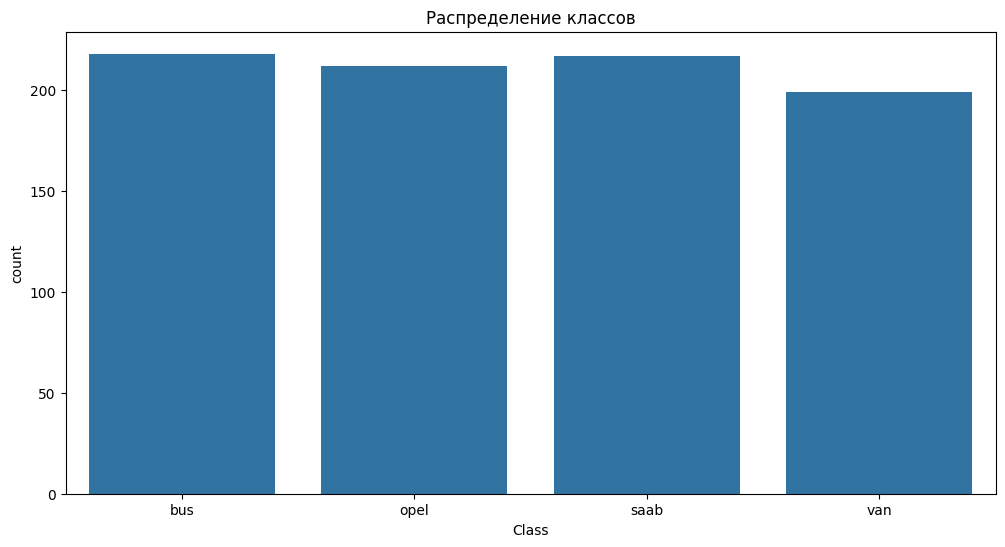

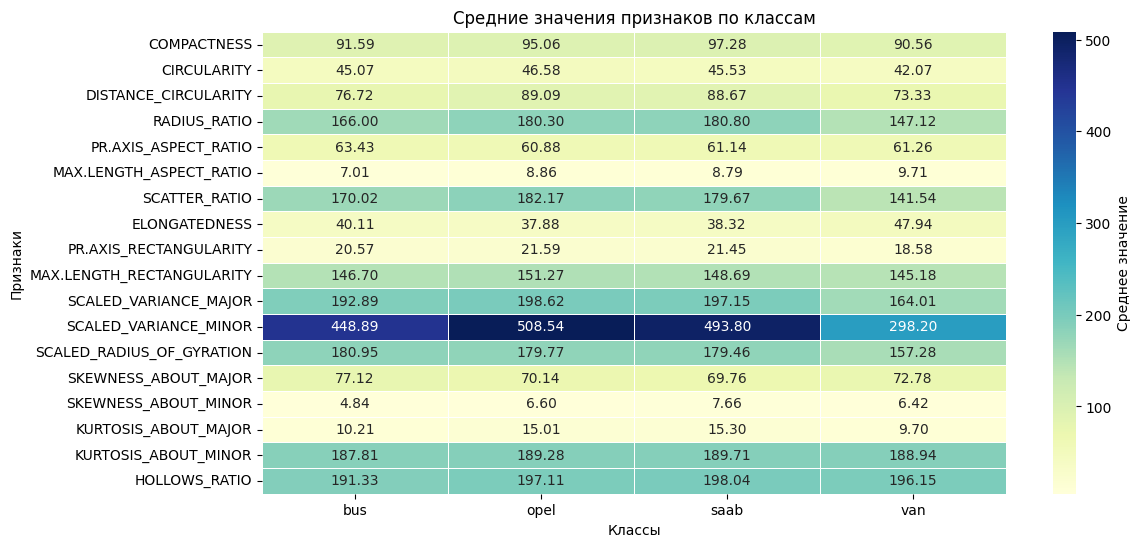

In [ ]:
data = pd.concat([X, y], axis = 1)
le = LabelEncoder()
data['Class'] = le.fit_transform(data['Class'])
class_names = le.classes_

plt.figure(figsize=(12, 6))
sns.countplot(x='Class', data=data)
plt.title('Распределение классов')
plt.xticks(ticks=[0, 1, 2, 3], labels=class_names)

class_stats = data.groupby('Class').agg(['mean', 'std', 'count'])
class_means = class_stats.xs('mean', axis=1, level=1).T
plt.figure(figsize=(12, 6))
sns.heatmap(class_means, annot=True, fmt=".2f", cmap="YlGnBu",
            linewidths=.5, cbar_kws={'label': 'Среднее значение'})
plt.title('Средние значения признаков по классам')
plt.ylabel('Признаки')
plt.xlabel('Классы')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_names)
plt.show()

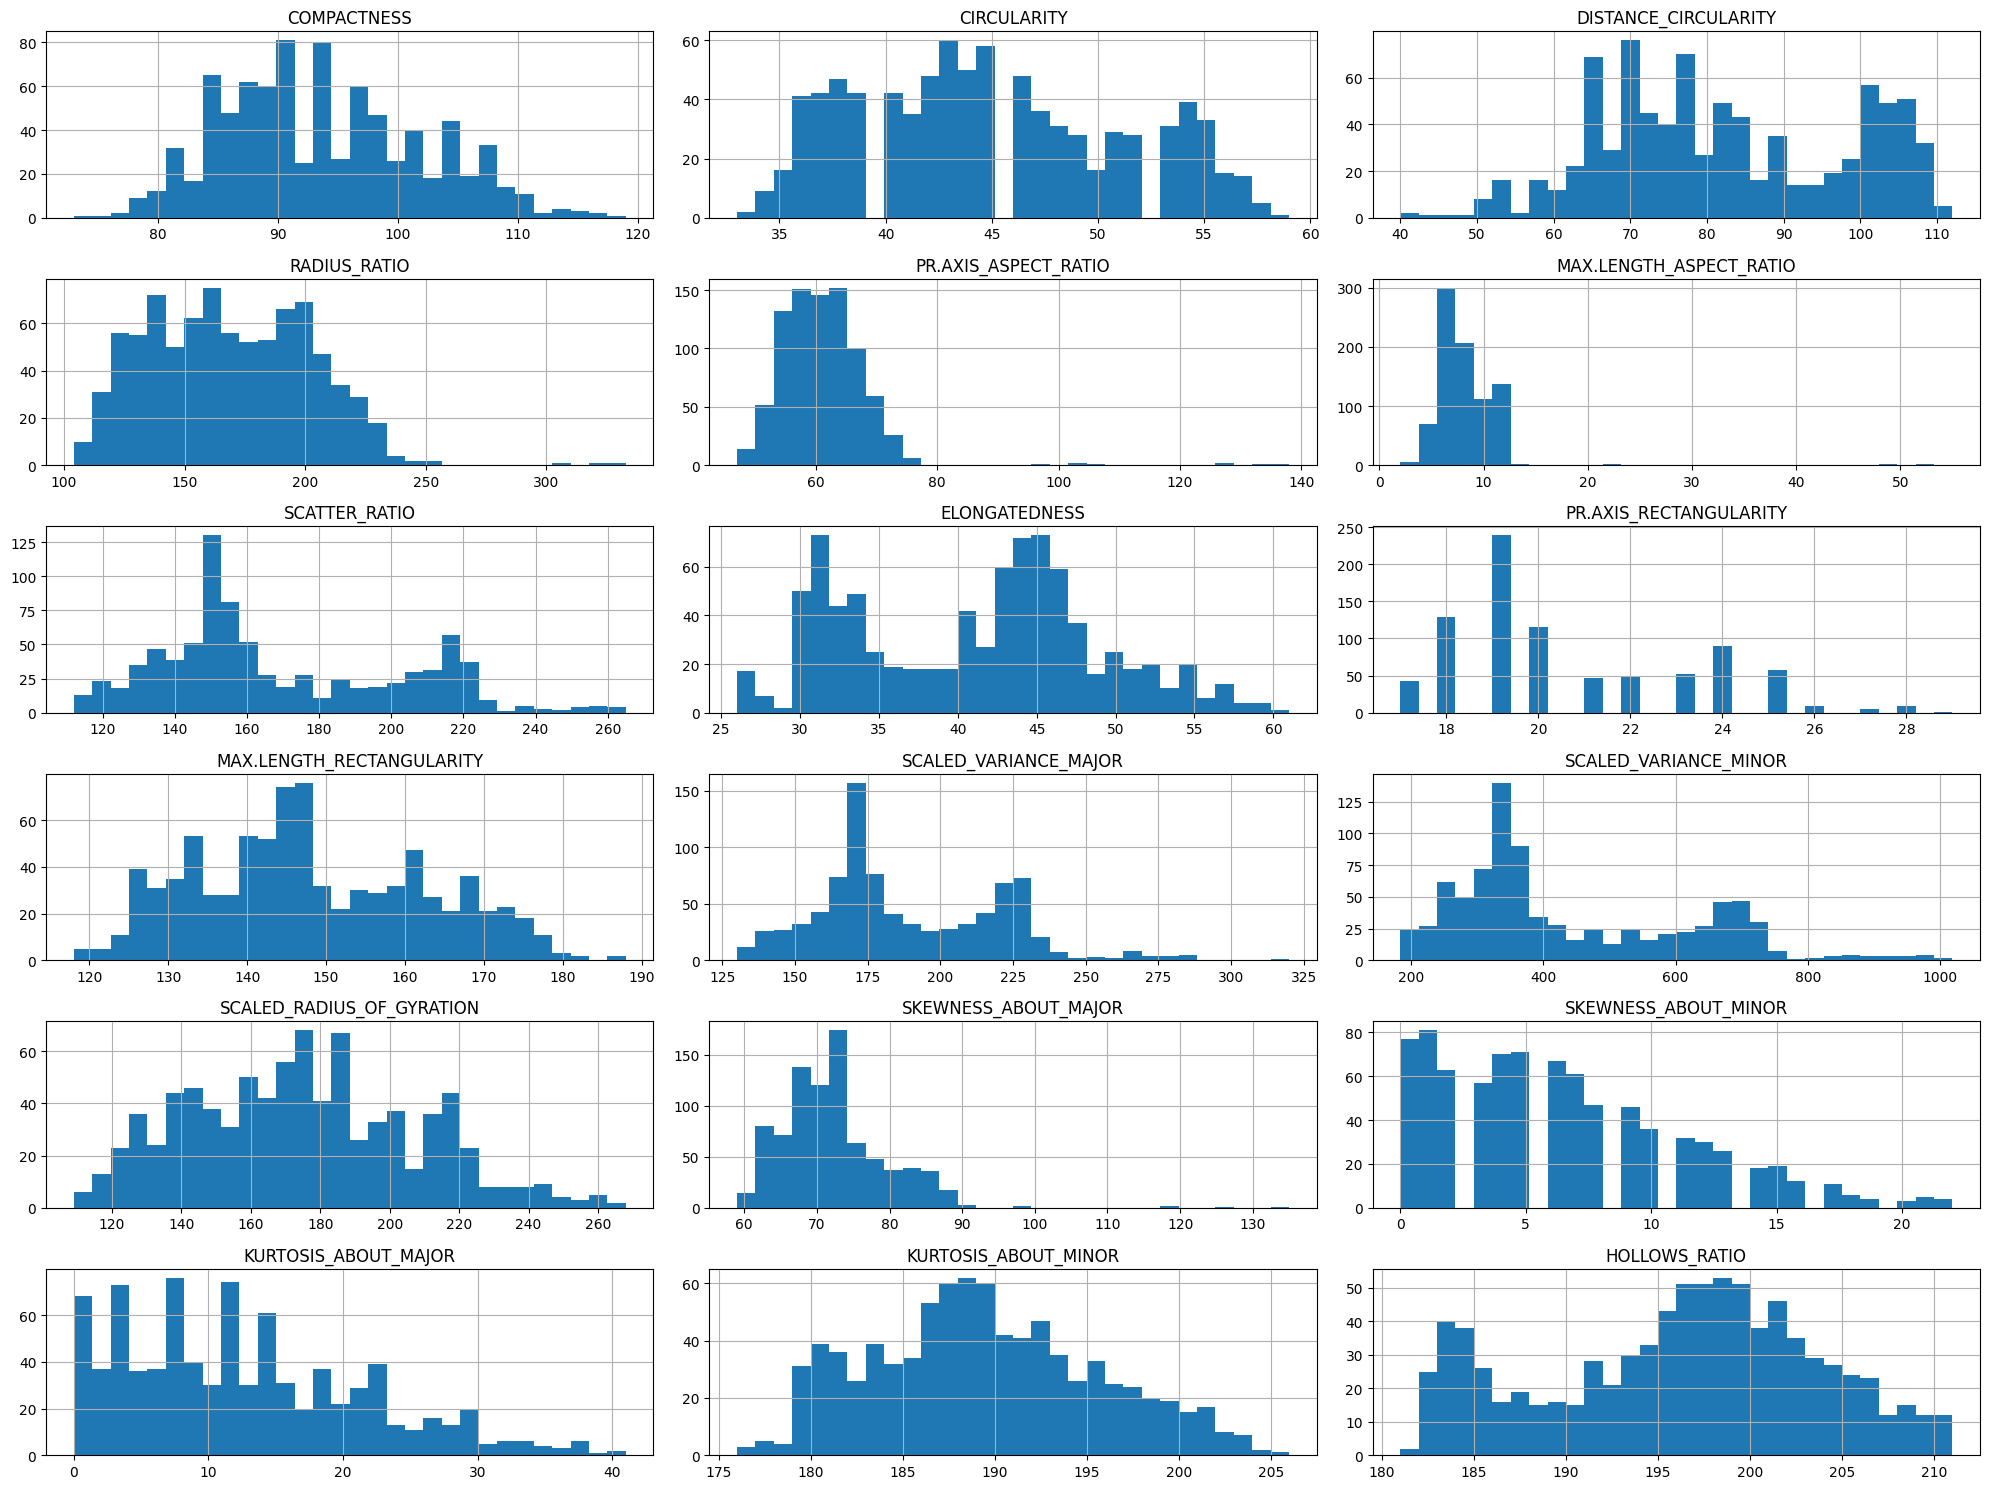

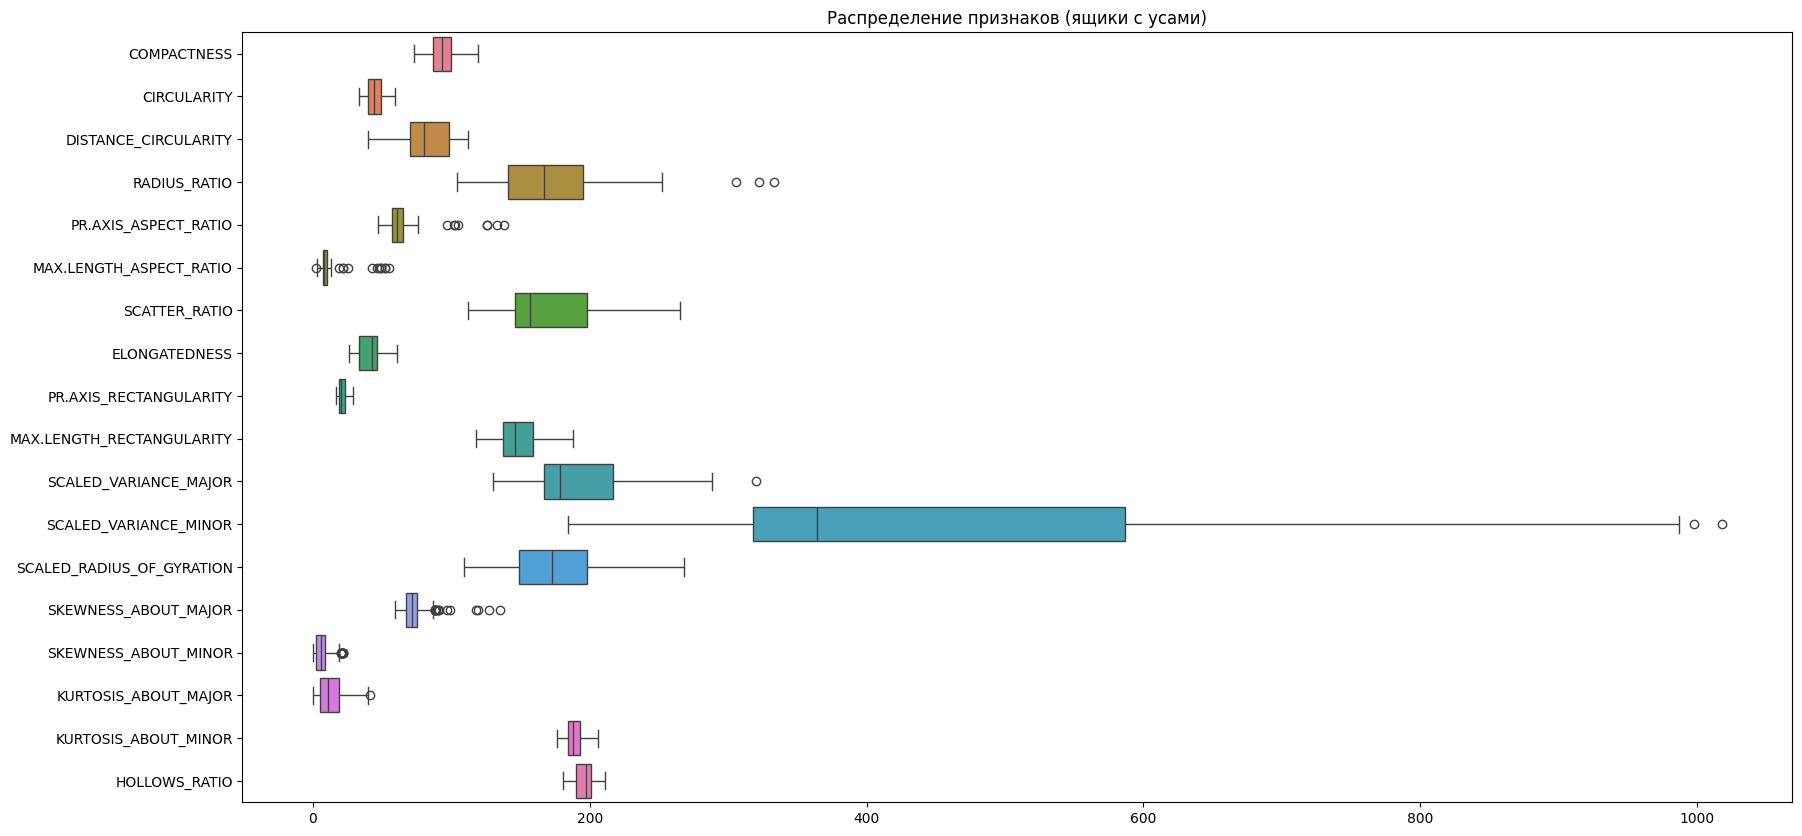

In [ ]:
X.hist(bins=30, figsize=(20, 15), layout=(6, 3))
plt.tight_layout()
plt.show()


plt.figure(figsize=(20, 10))
sns.boxplot(X, orient='h')
plt.title('Распределение признаков (ящики с усами)')
plt.show()

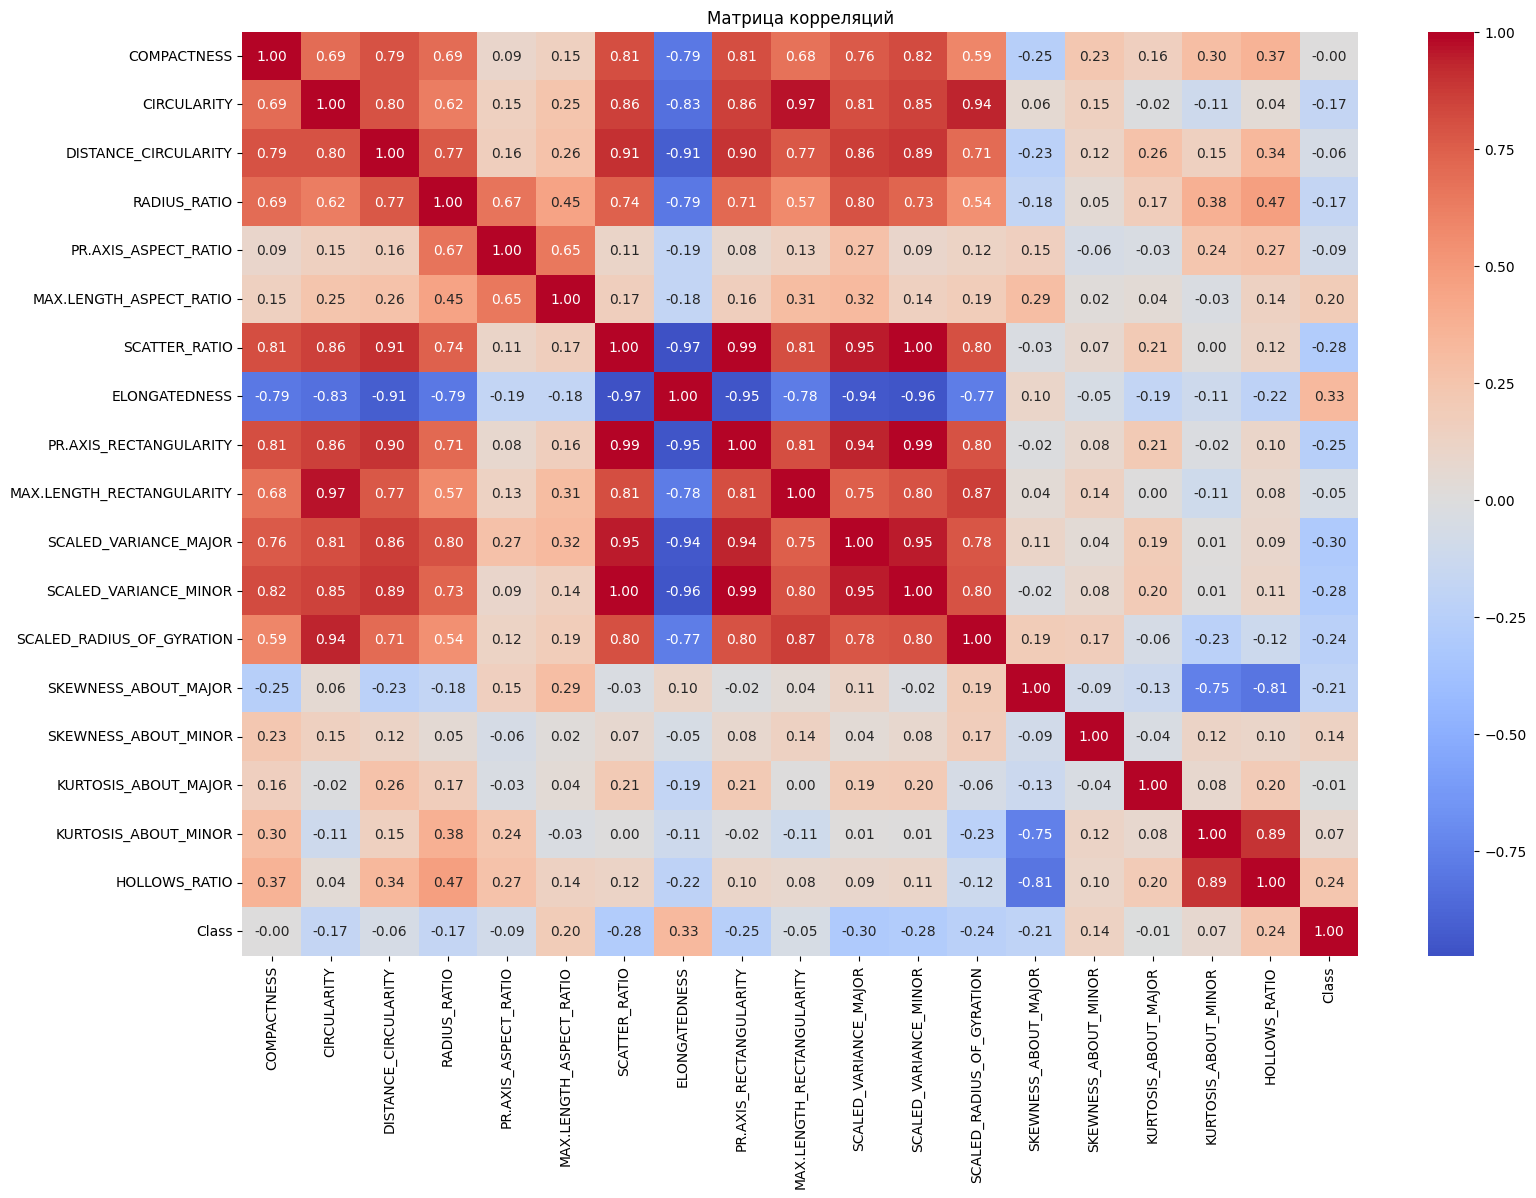

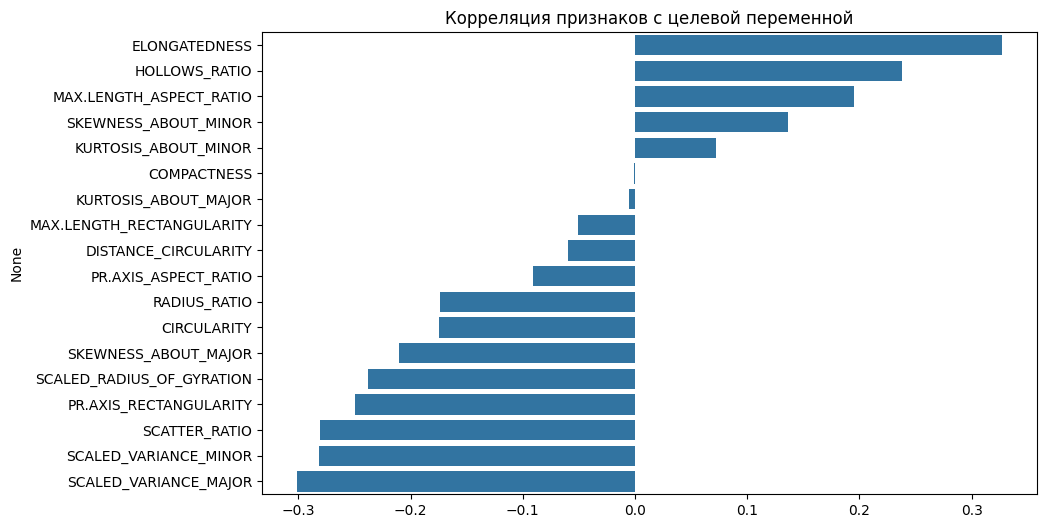

In [ ]:
plt.figure(figsize=(18, 12))
corr = data.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

corr_with_target = corr['Class'].sort_values(ascending=False)[1:]
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Корреляция признаков с целевой переменной')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Логистическая регрессия

In [ ]:
logreg_params = {
    'multi_class': 'multinomial',
    'solver': 'saga',
    'tol': 1e-3,
    'max_iter': 500,
    'random_state': 42
}

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0.1, 0.5, 0.9]
}

logreg = LogisticRegression(**logreg_params)
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)


best_logreg = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV F1-score: {grid_search.best_score_:.4f}")

y_pred = best_logreg.predict(X_test_scaled)
y_proba = best_logreg.predict_proba(X_test_scaled)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1-score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1'}
Best CV F1-score: 0.7905

Test Accuracy: 0.8235294117647058
Test F1-score: 0.8189812581914365

Classification Report:
              precision    recall  f1-score   support

         bus       0.96      0.98      0.97        44
        opel       0.72      0.55      0.62        42
        saab       0.67      0.80      0.73        44
         van       0.95      0.97      0.96        40

    accuracy                           0.82       170
   macro avg       0.82      0.82      0.82       170
weighted avg       0.82      0.82      0.82       170



## А что, если добавить PCA:

Text(0, 0.5, 'Explained Variance ratio')

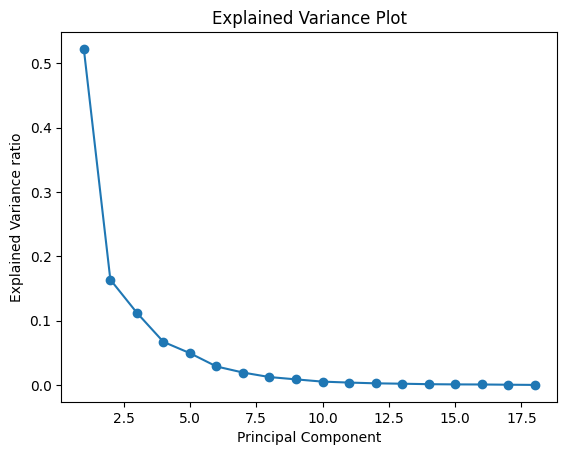

In [ ]:
pca_allcomponents = PCA()
pca_allcomponents.fit(X_train_scaled)
explained_variance = pca_allcomponents.explained_variance_ratio_

plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Explained Variance Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance ratio')

На мой взгляд, оптимальнее всего взять 7 компонент, так как именно на такое количество приходится бОльшая часть explained variance, судя по графику.

In [ ]:
pca = PCA(n_components = 7)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

logreg_withPCA = LogisticRegression(**logreg_params)
grid_search = GridSearchCV(logreg_withPCA, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

best_logreg_PCA = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV F1-score: {grid_search.best_score_:.4f}")

y_pred = best_logreg_PCA.predict(X_test_pca)
y_proba = best_logreg_PCA.predict_proba(X_test_pca)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1-score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Best parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1'}
Best CV F1-score: 0.6209

Test Accuracy: 0.6588235294117647
Test F1-score: 0.6477034649476229

Classification Report:
              precision    recall  f1-score   support

         bus       0.65      0.82      0.73        44
        opel       0.45      0.33      0.38        42
        saab       0.61      0.61      0.61        44
         van       0.88      0.88      0.88        40

    accuracy                           0.66       170
   macro avg       0.65      0.66      0.65       170
weighted avg       0.65      0.66      0.65       170



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# RandomForest

100%|██████████| 500/500 [06:35<00:00,  1.26it/s]


Text(0, 0.5, 'F1 Score')

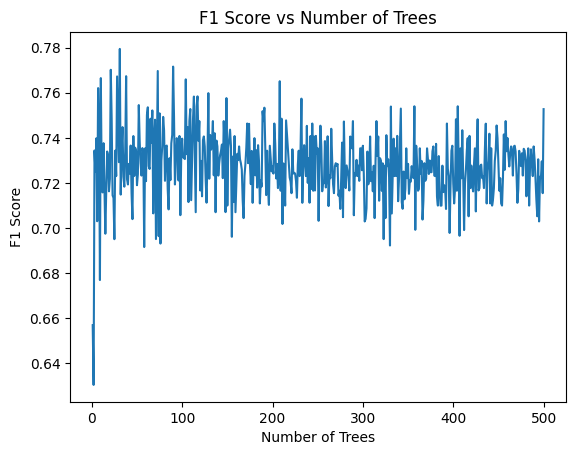

In [ ]:
n_trees = range(1, 501)
f1_scores = []
accuracy_scores = []

for n in tqdm(n_trees):
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

plt.plot(n_trees, f1_scores)
plt.title('F1 Score vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('F1 Score')

Text(0, 0.5, 'F1 Score')

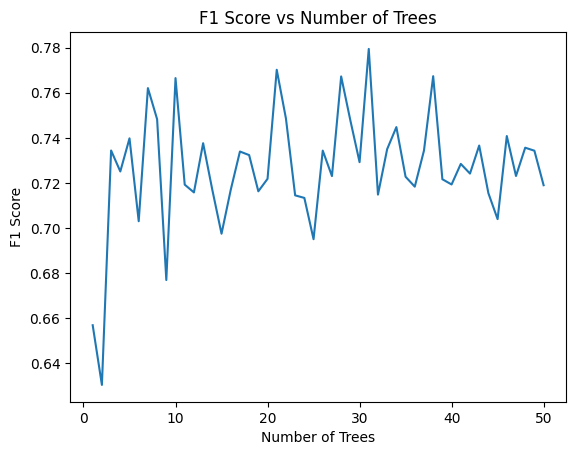

In [ ]:
plt.plot(n_trees[:50], f1_scores[:50])
plt.title('F1 Score vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('F1 Score')

In [ ]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1-score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Test Accuracy: 0.7529411764705882
Test F1-score: 0.7446252621733194

Classification Report:
              precision    recall  f1-score   support

         bus       0.92      1.00      0.96        44
        opel       0.56      0.43      0.49        42
        saab       0.55      0.61      0.58        44
         van       0.95      0.97      0.96        40

    accuracy                           0.75       170
   macro avg       0.75      0.75      0.75       170
weighted avg       0.74      0.75      0.74       170



<Axes: xlabel='Importance', ylabel='Feature'>

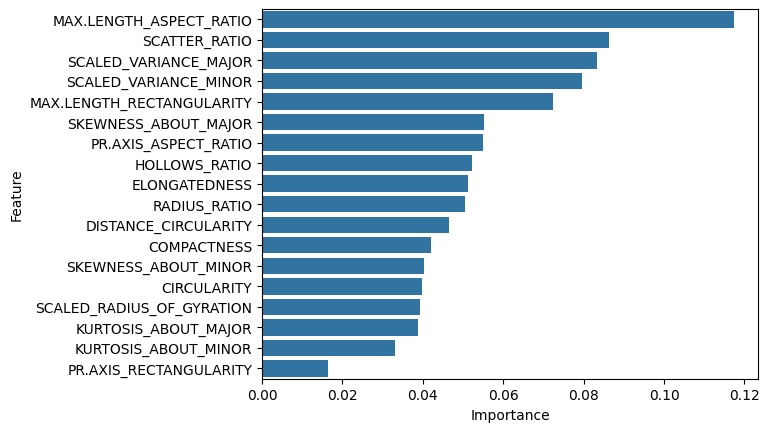

In [ ]:
importances = rf.feature_importances_
rf_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
rf_df = rf_df.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=rf_df)

# Catboost

In [ ]:
param_dist = {
    'depth': [3, 4, 5],
    'learning_rate': [0.01, 0.03],
    'iterations': [1500, 1700, 2000],
    'l2_leaf_reg': [4, 5, 6],
    'random_strength': [0.1, 0.3, 0.5]
}

random_search = RandomizedSearchCV(
    CatBoostClassifier(
        loss_function='MultiClass',
        verbose=0,
        random_state=42,
        border_count = 32,
        feature_border_type='GreedyLogSum',
        model_shrink_mode='Constant',
        boosting_type='Ordered'
    ),
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

best_cb = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV F1-score: {random_search.best_score_:.4f}")

y_pred_cb = best_cb.predict(X_test_scaled)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred_cb))
print("Test F1-score (best model):", f1_score(y_test, y_pred_cb, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_cb, target_names=class_names))

Best parameters: {'random_strength': 0.1, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 1700, 'depth': 4}
Best CV F1-score: 0.7605

Test Accuracy (best model): 0.7823529411764706
Test F1-score (best model): 0.7803674974263209

Classification Report:
              precision    recall  f1-score   support

         bus       0.98      0.98      0.98        44
        opel       0.58      0.52      0.55        42
        saab       0.62      0.66      0.64        44
         van       0.95      0.97      0.96        40

    accuracy                           0.78       170
   macro avg       0.78      0.78      0.78       170
weighted avg       0.78      0.78      0.78       170



In [ ]:
train_pool = Pool(X_train_scaled, y_train)
val_pool = Pool(X_test_scaled, y_test)

catboost_model = CatBoostClassifier(
    iterations=2600,
    learning_rate=0.03,
    depth=4,
    l2_leaf_reg = 5,
    random_strength = 0.1,
    border_count = 32,
    loss_function='MultiClass',
    verbose=100,
    random_state=42,
    feature_border_type='GreedyLogSum',
    model_shrink_mode='Constant',
    boosting_type='Ordered'
)


catboost_model.fit(train_pool,
                   eval_set=val_pool,
                   plot=True,
                   verbose=100)


y_pred_cb = catboost_model.predict(X_test_scaled)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred_cb))
print("Test F1-score (best model):", f1_score(y_test, y_pred_cb, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_cb, target_names=class_names))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.3574261	test: 1.3593280	best: 1.3593280 (0)	total: 53.6ms	remaining: 2m 19s
100:	learn: 0.6458815	test: 0.7108757	best: 0.7108757 (100)	total: 532ms	remaining: 13.2s
200:	learn: 0.5086709	test: 0.6035357	best: 0.6035357 (200)	total: 1s	remaining: 11.9s
300:	learn: 0.4369711	test: 0.5516692	best: 0.5516692 (300)	total: 1.47s	remaining: 11.2s
400:	learn: 0.3925403	test: 0.5244320	best: 0.5244320 (400)	total: 1.91s	remaining: 10.5s
500:	learn: 0.3600781	test: 0.5059207	best: 0.5059207 (500)	total: 2.39s	remaining: 10s
600:	learn: 0.3313608	test: 0.4909482	best: 0.4909482 (600)	total: 2.84s	remaining: 9.44s
700:	learn: 0.3078402	test: 0.4789798	best: 0.4789798 (700)	total: 4.46s	remaining: 12.1s
800:	learn: 0.2878926	test: 0.4674964	best: 0.4674964 (800)	total: 5.98s	remaining: 13.4s
900:	learn: 0.2702201	test: 0.4578798	best: 0.4578798 (900)	total: 7.68s	remaining: 14.5s
1000:	learn: 0.2535003	test: 0.4509038	best: 0.4509038 (1000)	total: 8.13s	remaining: 13s
1100:	learn: 0.24

<Axes: xlabel='Importance', ylabel='Feature'>

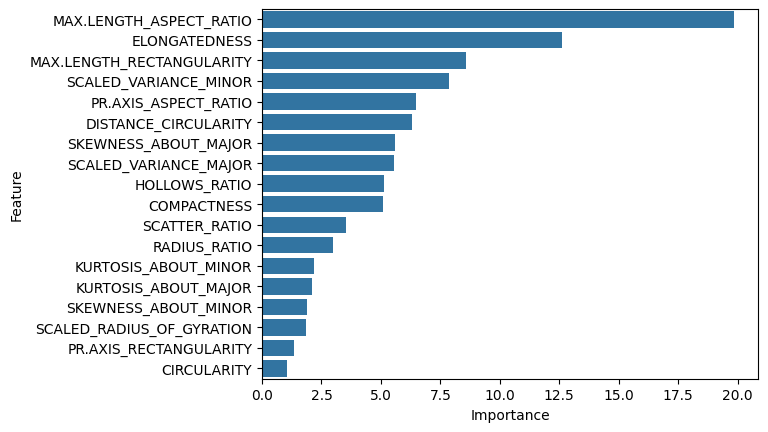

In [ ]:
importances = catboost_model.get_feature_importance()
cb_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
cb_df = cb_df.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=cb_df)

В итоге, наилучшие метрики на тестовой выборке показала логистическая регрессия. Бустинг, вероятно, не дал преимущества из-за небольшой размерности датасета - как признаков, так и измерений для бустинга было недостаточно.